<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

# 3.3 Validation
In this exercise, we focus on the validation of the results we have produced. In general, the accuracy of a satellite derived product is expressed by comparing it to in-situ measurements. Furthermore, we will compare the resuling snow cover time series to the runoff of the catchment to check the plausibility of the observed relationship.

The steps involved in this analysis:
- Generate Datacube time-series of snowmap,
- Load _in-situ_ datasets: snow depth station measurements,
- Pre-process and filter _in-situ_ datasets to match area of interest, 
- Perform validation of snow-depth measurements,
- Plausibility check with runoff of the catchment

More information on the openEO Python Client: https://open-eo.github.io/openeo-python-client/index.html

## Libraries

In [1]:
import json
from datetime import date
import numpy as np
import pandas as pd

import xarray as xr
import rioxarray as rio

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

import geopandas as gpd
import leafmap.foliumap as leafmap
# from leafmap import leafmap
# import leafmap
import openeo

## Login
Connect to the Copernicus Dataspace Ecosystem.

In [2]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/')

Login.

In [3]:
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

Check if the login worked.

In [ ]:
conn.describe_account()

## Region of Interest

Load the Val Passiria Catchment, our region of interest. And plot it.

In [5]:
catchment_outline = gpd.read_file('data/catchment_outline.geojson')

In [6]:
center = (float(catchment_outline.centroid.y), float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('data/catchment_outline.geojson', layer_name="catchment")
m

## Generate Datacube of Snowmap

We have prepared the workflow to generate the snow map as a python function `calculate_sca()`. It's available in `cubes_utilities.py`.

In [7]:
%run cubes_utilities.py

In [8]:
bbox = catchment_outline.bounds.iloc[0]
temporal_extent = ["2018-02-01", "2018-06-30"]
snow_map_cloud_free = calculate_sca(conn, bbox, temporal_extent)
snow_map_cloud_free

## Load snow-station in-situ data
Load the _in-situ_ datasets, snow depth station measurements. They have been compiled in the ClirSnow project and are available here: [Snow Cover in the European Alps](https://zenodo.org/record/5109574) with stations in our area of interest. 

We have made the data available for you already. We can load it directly.

In [9]:
# load snow station datasets from zenodo:: https://zenodo.org/record/5109574
station_df = pd.read_csv("data/data_daily_IT_BZ.csv")
# station_df.head()

In [10]:
# load additional metadata for acessing the station geometries
station_df_meta = pd.read_csv("data/meta_all.csv")
# station_df_meta.head()

## Pre-process and filter _in-situ_ snow station measurements

### Filter Temporally
Filter the in-situ datasets to match the snow-map time series using the function `station_temporal_filter()` from `cubes_utilities.py`.

In [11]:
start_date = "2018-02-01"
end_date = "2018-06-30"

snow_stations = station_temporal_filter(station_daily_df = station_df, 
                                        station_meta_df = station_df_meta,
                                        start_date = start_date,
                                        end_date = end_date)
# snow_stations.head()

### Filter Spatially
Filter the in-situ datasets into the catchment area of interest using `station_spatial_filter()` from `cubes_utilities.py`.

In [12]:
catchment_stations = station_spatial_filter(snow_stations, catchment_outline)
# catchment_stations.head()

### Plot the filtered stations
Visualize location of snow stations

In [13]:
print("There are", len(np.unique(catchment_stations.Name)), "unique stations within our catchment area of interest")

There are 5 unique stations within our catchment area of interest


**_Quick Hint: Remember the number of stations within the catchment for the final quiz exercise_**

### Convert snow depth to snow presence
The stations are measuring snow depth. We only need the binary information on the presence of snow (yes, no). We're using the function `binarize_snow()` from `cubes_utilities.py`.

In [14]:
catchment_stations = catchment_stations.assign(snow_presence=catchment_stations.apply(binarize_snow, axis=1))
catchment_stations.head()

,Provider,Name,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry,snow_presence
Date,,,,,,,,,,,,
2018-02-01,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268),0
2018-02-01,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503),0
2018-02-01,IT_BZ,Plata_Osservatore,2.0,55.0,2.0,55.0,55.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),1
2018-02-01,IT_BZ,S_Leonardo_in_Passiria_Osservatore,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906),0
2018-02-01,IT_BZ,Scena_Osservatore,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960),0


### Save the pre-processed snow station measurements
Save snow stations within catchment as GeoJSON

In [15]:
with open("results/catchment_stations.geojson", "w") as file:
    file.write(catchment_stations.to_json())

## Extract SCA from the data cube per station

### Prepare snow station data for usage in openEO
Create a buffer of approximately 80 meters (0.00075 degrees) around snow stations and visualize them.

In [16]:
catchment_stations_gpd = gpd.read_file("results/catchment_stations.geojson")
mappy =leafmap.Map(center=center, zoom=16)
mappy.add_vector('data/catchment_outline.geojson', layer_name="catchment")
mappy.add_gdf(catchment_stations_gpd, layer_name="catchment_station")

catchment_stations_gpd["geometry"] = catchment_stations_gpd.geometry.buffer(0.00075)
mappy.add_gdf(catchment_stations_gpd, layer_name="catchment_station_buffer")
mappy

Convert the unique geometries to Feature Collection to be used in a openEO process.

In [17]:
catchment_stations_fc = json.loads(
    catchment_stations_gpd.geometry.iloc[:5].to_json()
)

### Extract SCA from the data cube per station
We exgtract the SCA value of our data cube at the buffered station locations. Therefore we use the process `aggregate_spatial()` with the aggregation method `median()`. This gives us the most common value in the buffer (snow or snowfree).

In [18]:
snowmap_per_station= snow_map_cloud_free.aggregate_spatial(catchment_stations_fc, reducer="median")
snowmap_per_station

Create a batch job on the cloud platform. And start it.

In [19]:
snowmap_cloudfree_json = snowmap_per_station.save_result(format="JSON")
job = snowmap_cloudfree_json.create_job(title="snow_map")
job.start_job()

Check the status of the job. And download once it's finished.

In [36]:
job.status()

'created'

In [ ]:
if job.status() == "finished":
    results = job.get_results()
    results.download_files("results/snowmap/")

Open the snow covered area time series extracted at the stations. We'll have a look at it in a second.

In [19]:
with open("results/snowmap/timeseries.json","r") as file:
    snow_time_series = json.load(file)

## Combine station measurements and the extracted SCA from our data cube
The **station measurements** are **daily** and all of the stations are combined in **one csv file**. 
The **extracted SCA values** are in the best case **six-daily** (Sentinel-2 repeat rate) and also all stations are in **one json file**.
We will need to join the the extracted SCA with the station measurements by station (and time (selecting the corresponding time steps)

### Extract snow values from SCA extracted at the station location
Let's have a look at the data structure first

In [21]:
dates = [k.split("T")[0] for k in snow_time_series]
snow_val_smartino = [snow_time_series[k][0][0] for k in snow_time_series]
snow_val_rifiano = [snow_time_series[k][1][0] for k in snow_time_series]
snow_val_plata = [snow_time_series[k][2][0] for k in snow_time_series]
snow_val_sleonardo = [snow_time_series[k][3][0] for k in snow_time_series]
snow_val_scena = [snow_time_series[k][4][0] for k in snow_time_series]

### Match in-situ measurements to dates in SCA 
Let's have a look at the in-situ measurement data set.

In [82]:
catchment_stations_gpd.sample(10)

,id,Provider,Name,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,snow_presence,geometry
302,2018-04-02,IT_BZ,S_Leonardo_in_Passiria_Osservatore,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,0,"POLYGON ((11.24788 46.80906, 11.24787 46.80899..."
427,2018-04-27,IT_BZ,Scena_Osservatore,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,0,"POLYGON ((11.19158 46.68960, 11.19158 46.68952..."
313,2018-04-04,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,0,"POLYGON ((11.18436 46.70503, 11.18435 46.70496..."
652,2018-06-11,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261..."
668,2018-06-14,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261..."
397,2018-04-21,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261..."
585,2018-05-29,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,0,"POLYGON ((11.18436 46.70503, 11.18435 46.70496..."
213,2018-03-15,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261..."
14,2018-02-03,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261..."
615,2018-06-04,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,0,"POLYGON ((11.18436 46.70503, 11.18435 46.70496..."


We are going to extract each station and keep only the dates that are available in the SCA results.

In [23]:
catchment_stations_gpd_smartino = catchment_stations_gpd.query("Name == 'S_Martino_in_Passiria_Osservatore'")
catchment_stations_gpd_smartino = catchment_stations_gpd_smartino[
    catchment_stations_gpd_smartino.id.isin(dates)
]

catchment_stations_gpd_rifiano = catchment_stations_gpd.query("Name == 'Rifiano_Beobachter'")
catchment_stations_gpd_rifiano = catchment_stations_gpd_rifiano[
    catchment_stations_gpd_rifiano.id.isin(dates)
]

catchment_stations_gpd_plata = catchment_stations_gpd.query("Name == 'Plata_Osservatore'")
catchment_stations_gpd_plata = catchment_stations_gpd_plata[
    catchment_stations_gpd_plata.id.isin(dates)
]

catchment_stations_gpd_sleonardo = catchment_stations_gpd.query("Name == 'S_Leonardo_in_Passiria_Osservatore'")
catchment_stations_gpd_sleonardo = catchment_stations_gpd_sleonardo[
    catchment_stations_gpd_sleonardo.id.isin(dates)
]

catchment_stations_gpd_scena = catchment_stations_gpd.query("Name == 'Scena_Osservatore'")
catchment_stations_gpd_scena = catchment_stations_gpd_scena[
    catchment_stations_gpd_scena.id.isin(dates)
]

### Combine in-situ measurements with SCA results at the stations 
The in situ measurements and the SCA are combined into one data set per station. This will be the basis for the validation.

In [24]:
smartino_snow = assign_site_snow(catchment_stations_gpd_smartino, snow_val_smartino)
rifiano_snow = assign_site_snow(catchment_stations_gpd_rifiano, snow_val_rifiano)
plata_snow = assign_site_snow(catchment_stations_gpd_plata, snow_val_plata)
sleonardo_snow = assign_site_snow(catchment_stations_gpd_sleonardo, snow_val_sleonardo)
scena_snow = assign_site_snow(catchment_stations_gpd_scena, snow_val_scena)                                                                    

Let's have a look at the SCA extracted at the station San Martino and it's in situ measurements.

In [27]:
catchment_stations_gpd_plata.sample(5)

,id,Provider,Name,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,snow_presence,geometry,cube_snow
450,2018-05-02,IT_BZ,Plata_Osservatore,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,0,"POLYGON ((11.17772 46.82285, 11.17771 46.82277...",NaN
12,2018-02-03,IT_BZ,Plata_Osservatore,0.0,60.0,0.0,60.0,60.0,11.176968,46.822847,1130.0,1,"POLYGON ((11.17772 46.82285, 11.17771 46.82277...",NaN
254,2018-03-23,IT_BZ,Plata_Osservatore,0.0,8.0,0.0,8.0,8.0,11.176968,46.822847,1130.0,1,"POLYGON ((11.17772 46.82285, 11.17771 46.82277...",0.0
502,2018-05-12,IT_BZ,Plata_Osservatore,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,0,"POLYGON ((11.17772 46.82285, 11.17771 46.82277...",NaN
2,2018-02-01,IT_BZ,Plata_Osservatore,2.0,55.0,2.0,55.0,55.0,11.176968,46.822847,1130.0,1,"POLYGON ((11.17772 46.82285, 11.17771 46.82277...",NaN


Display snow presence threshold in in-situ data for Plato Osservatore

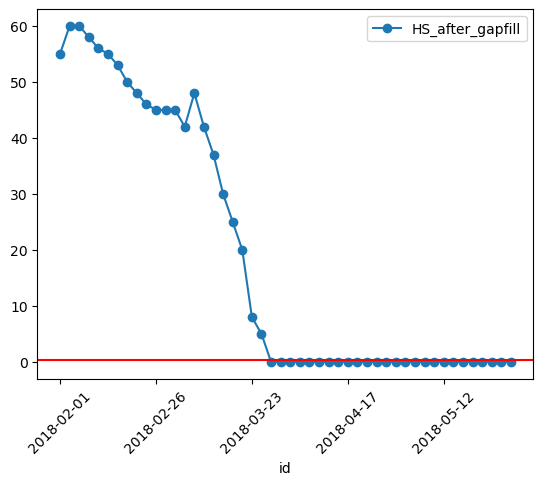

In [28]:
catchment_stations_gpd_plata.plot(x="id", y="HS_after_gapfill",rot=45,kind="line",marker='o')
plt.axhline(y = 0.4, color = "r", linestyle = "-")
plt.show()

## Validate the SCA results with the snow station measurements 
Now that we have combined the SCA results with the snow station measurements we can start the actual validation. A **confusion matrix** compares the classes of the station data to the classes of the SCA result. The numbers can be used to calculate the accuracy (correctly classified cases / all cases).

|             | no_snow | snow    |
|-------------|---------|---------|
| **no_snow** | correct | error   |
| **snow**    | error   | correct |

In [37]:
import seaborn as sns

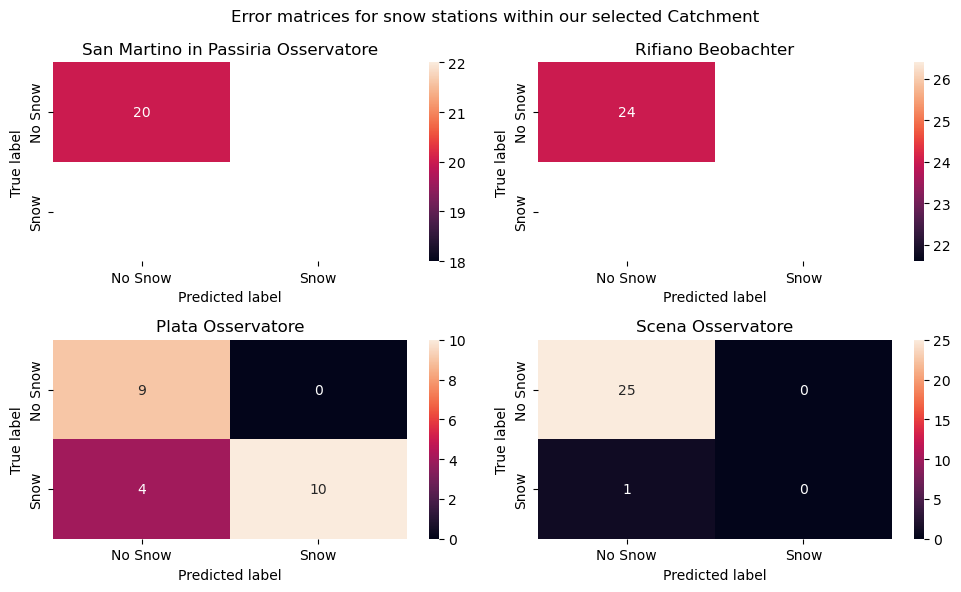

In [81]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))

fig.suptitle("Error matrices for snow stations within our selected Catchment")
sns.heatmap(validation_metrics(smartino_snow)[1], annot=True, xticklabels=["No Snow", "Snow"], yticklabels=["No Snow", "Snow"], ax=ax1)
ax1.set_title("San Martino in Passiria Osservatore")
ax1.set(xlabel="Predicted label", ylabel="True label")


sns.heatmap(validation_metrics(rifiano_snow)[1], annot=True, xticklabels=["No Snow", "Snow"], yticklabels=["No Snow", "Snow"], ax=ax2)
ax2.set_title("Rifiano Beobachter")
ax2.set(xlabel="Predicted label", ylabel="True label")


sns.heatmap(validation_metrics(plata_snow)[1], annot=True, xticklabels=["No Snow", "Snow"], yticklabels=["No Snow", "Snow"], ax=ax3)
ax3.set_title("Plata Osservatore")
ax3.set(xlabel="Predicted label", ylabel="True label")


sns.heatmap(validation_metrics(scena_snow)[1], annot=True, xticklabels=["No Snow", "Snow"], yticklabels=["No Snow", "Snow"], ax=ax4)
ax4.set_title("Scena Osservatore")
ax4.set(xlabel="Predicted label", ylabel="True label")

fig.tight_layout()

The **accuracy** of the snow estimate from the satellite image computation for each station is shown below: 


| **On-site snow station**             | **Accuracy**|
|--------------------------------------|-------------|
| San Martino in Passiria Osservatore  | **100.00%** |
| Rifiano Beobachter                   | **100.00%** |
| Plata Osservatore                    |    82.61%   |
| San Leonardo in Passiria Osservatore |    NaN      |
| Scena Osservatore                    |    96.15%   |

The fifth and last station **San Leonardo in Passiria Osservatore** recorded **_NaNs_** for snow depths for our selected dates, which could potentially be as a results of malfunctioning on-site equipments. Hence, we are not able to verify for it. But overall, the validation shows a 100% accuracy for stations **San Martino in Passiria Osservatore** and **Rifiano Beobachter**, while station **Plata Osservatore** has a lot more False Positive (4) than the other stations.This shows a good match between estimated snow values from satellite datasets and on-the ground measurements of the presence of snow. 

## Compare to discharge data
In addition to computing metrics for validating the data, we also check the plausibility of our results. We compare our results with another measure with a known relationship. In this case, we compare the **snow cover area** time series with the **discharge** time-series at the main outlet of the catchment. We suspect that after snow melting starts, with a temporal lag, the runoff will increase. Let's see if this holds true.

Load the discharge data at Meran, the main outlet of the catchment. We have prepared this data set for you, it's extracted from Eurac's [Environmental Data Platform Alpine Drought Observatory Discharge Hydrological Datasets](https://edp-portal.eurac.edu/discovery/9e195271-02ae-40be-b3a7-525f57f53c80)). 

In [33]:
discharge_ds = pd.read_csv('data/ADO_DSC_ITH1_0025.csv', 
                           sep=',', index_col='Time', parse_dates=True)
discharge_ds.head()

,discharge_m3_s
Time,
1994-01-01 01:00:00,4.03
1994-01-02 01:00:00,3.84
1994-01-03 01:00:00,3.74
1994-01-04 01:00:00,3.89
1994-01-05 01:00:00,3.80


Load the SCA time series we have generated in a previous exercise. It's the time series of the aggregated snow cover area percentage for the whole catchment.

In [34]:
snow_perc_df = pd.read_csv("data/filtered_snow_perc.csv", 
                          sep=',', index_col='time', parse_dates=True)

Let's plot the relationship between the snow covered area and the discharge in the catchment.

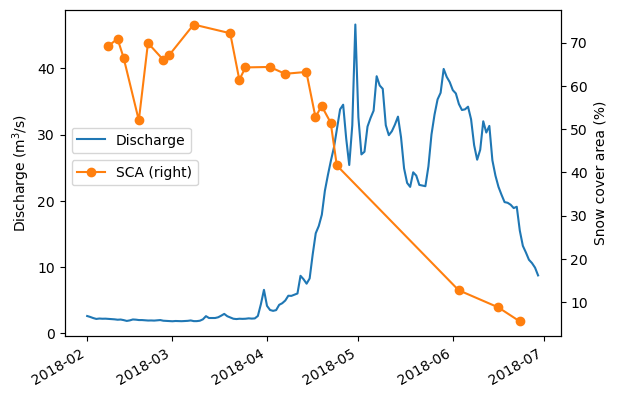

In [35]:
start_date = date(2018, 2, 1)
end_date = date(2018, 6, 30)
# filter discharge data to start and end dates
discharge_ds = discharge_ds.loc[start_date:end_date]

ax1 = discharge_ds.discharge_m3_s.plot(label='Discharge', xlabel='', ylabel='Discharge (m$^3$/s)')
ax2 = snow_perc_df["perc_snow"].plot(marker='o', secondary_y=True, label='SCA', xlabel='', ylabel='Snow cover area (%)')
ax1.legend(loc='center left', bbox_to_anchor=(0, 0.6))
ax2.legend(loc='center left', bbox_to_anchor=(0, 0.5))
plt.show()

The relationship looks as expected! Once the snow cover decreases the runoff increases!